# 17a: Winner vs Loser Enrichment Analysis

**Goal**: Identify which dominoes are over/under-represented in high E[V] hands.

**Key Questions**:
1. Which dominoes are enriched in top 25% E[V] hands?
2. Which are depleted in top hands?
3. Are these effects statistically significant?

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

from forge.analysis.utils import viz
from forge.oracle import schema
from forge.oracle.rng import deal_from_seed

viz.setup_notebook_style()
print("Ready")

Ready


## 1. Load and Prepare Data

In [2]:
# Load unified features
features_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(features_path)

# Reconstruct hands
hands_data = []
for _, row in df.iterrows():
    seed = int(row['base_seed'])
    hands = deal_from_seed(seed)
    p0_hand = set(hands[0])
    hands_data.append({
        'seed': seed,
        'hand': p0_hand,
        'V_mean': row['V_mean'],
    })

print(f"Loaded {len(hands_data)} hands")
print(f"E[V] range: [{df['V_mean'].min():.1f}, {df['V_mean'].max():.1f}]")

Loaded 200 hands
E[V] range: [-29.3, 42.0]


In [3]:
# Split into winners (top 25%) and losers (bottom 25%)
v_values = [h['V_mean'] for h in hands_data]
q75 = np.percentile(v_values, 75)
q25 = np.percentile(v_values, 25)

winners = [h for h in hands_data if h['V_mean'] >= q75]
losers = [h for h in hands_data if h['V_mean'] <= q25]

print(f"Q75 (winner threshold): {q75:.1f}")
print(f"Q25 (loser threshold): {q25:.1f}")
print(f"Winners (top 25%): {len(winners)} hands")
print(f"Losers (bottom 25%): {len(losers)} hands")

Q75 (winner threshold): 27.5
Q25 (loser threshold): 4.0
Winners (top 25%): 50 hands
Losers (bottom 25%): 51 hands


In [4]:
# Create domino name mapping
def domino_name(d_id: int) -> str:
    pips = schema.domino_pips(d_id)
    return f"{pips[0]}-{pips[1]}"

DOMINO_NAMES = [domino_name(d) for d in range(28)]

## 2. Fisher's Exact Test for Each Domino

For each domino, create a 2×2 contingency table:

|            | Winner | Loser |
|------------|--------|-------|
| Has domino |   a    |   b   |
| No domino  |   c    |   d   |

Fisher's exact test determines if the domino is significantly associated with winning.

In [5]:
results = []

for d in range(28):
    # Count presence in winners vs losers
    winners_with = sum(1 for h in winners if d in h['hand'])
    winners_without = len(winners) - winners_with
    losers_with = sum(1 for h in losers if d in h['hand'])
    losers_without = len(losers) - losers_with
    
    # 2x2 contingency table
    table = [[winners_with, losers_with],
             [winners_without, losers_without]]
    
    # Fisher's exact test (two-sided)
    odds_ratio, p_value = fisher_exact(table)
    
    # Enrichment ratio (relative frequency in winners vs losers)
    freq_winners = winners_with / len(winners) if len(winners) > 0 else 0
    freq_losers = losers_with / len(losers) if len(losers) > 0 else 0
    enrichment = (freq_winners / freq_losers) if freq_losers > 0 else float('inf')
    log2_enrichment = np.log2(enrichment) if enrichment > 0 and enrichment != float('inf') else 0
    
    results.append({
        'domino': DOMINO_NAMES[d],
        'd_id': d,
        'winners_with': winners_with,
        'losers_with': losers_with,
        'freq_winners': freq_winners,
        'freq_losers': freq_losers,
        'odds_ratio': odds_ratio,
        'log2_enrichment': log2_enrichment,
        'p_value': p_value,
    })

results_df = pd.DataFrame(results)

In [6]:
# Apply multiple testing correction (BH FDR)
reject, p_adj, _, _ = multipletests(results_df['p_value'], alpha=0.05, method='fdr_bh')
results_df['p_adjusted'] = p_adj
results_df['significant'] = reject

# Sort by enrichment
results_df = results_df.sort_values('log2_enrichment', ascending=False)

print("Top 10 Enriched in Winners:")
print(results_df.head(10)[['domino', 'freq_winners', 'freq_losers', 'log2_enrichment', 'p_value', 'p_adjusted', 'significant']].to_string(index=False))

print("\n\nTop 10 Depleted in Winners (Enriched in Losers):")
print(results_df.tail(10)[['domino', 'freq_winners', 'freq_losers', 'log2_enrichment', 'p_value', 'p_adjusted', 'significant']].to_string(index=False))

Top 10 Enriched in Winners:
domino  freq_winners  freq_losers  log2_enrichment  p_value  p_adjusted  significant
   5-5          0.50     0.176471         1.502500 0.000726    0.016519         True
   4-4          0.40     0.156863         1.350497 0.007819    0.072978        False
   3-3          0.28     0.117647         1.250962 0.048438    0.271251        False
   6-6          0.32     0.156863         1.028569 0.064285    0.285920        False
   5-0          0.30     0.156863         0.935460 0.101095    0.353834        False
   4-3          0.28     0.176471         0.665999 0.242882    0.618245        False
   2-2          0.26     0.176471         0.559084 0.343474    0.726903        False
   2-0          0.34     0.235294         0.531069 0.277168    0.646725        False
   5-2          0.28     0.215686         0.376492 0.495989    0.816922        False
   2-1          0.32     0.274510         0.221214 0.667193    0.889590        False


Top 10 Depleted in Winners (Enriche

In [7]:
# Summary statistics
n_significant = results_df['significant'].sum()
n_enriched = ((results_df['log2_enrichment'] > 0) & results_df['significant']).sum()
n_depleted = ((results_df['log2_enrichment'] < 0) & results_df['significant']).sum()

print(f"\nSignificant at FDR < 0.05: {n_significant} dominoes")
print(f"  Enriched in winners: {n_enriched}")
print(f"  Depleted in winners: {n_depleted}")


Significant at FDR < 0.05: 2 dominoes
  Enriched in winners: 1
  Depleted in winners: 1


## 3. Volcano Plot

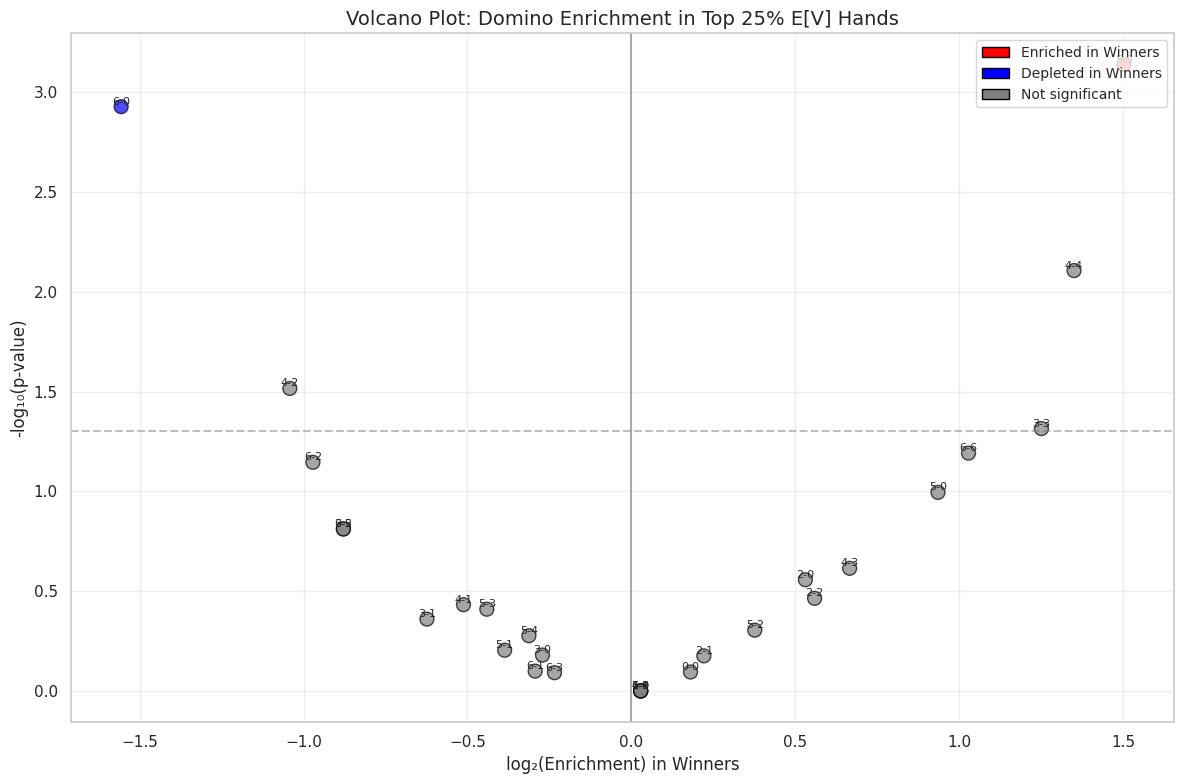

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))

# -log10(p) for y-axis
results_df['neg_log10_p'] = -np.log10(results_df['p_value'].clip(lower=1e-10))

# Color by significance and direction
colors = []
for _, row in results_df.iterrows():
    if row['significant'] and row['log2_enrichment'] > 0:
        colors.append('red')  # Enriched in winners
    elif row['significant'] and row['log2_enrichment'] < 0:
        colors.append('blue')  # Depleted in winners
    else:
        colors.append('gray')

ax.scatter(results_df['log2_enrichment'], results_df['neg_log10_p'], 
           c=colors, s=100, alpha=0.7, edgecolors='black')

# Label all points
for _, row in results_df.iterrows():
    ax.annotate(row['domino'], (row['log2_enrichment'], row['neg_log10_p']), 
                fontsize=8, ha='center', va='bottom')

# Significance threshold line
p_threshold = 0.05
ax.axhline(-np.log10(p_threshold), color='gray', linestyle='--', alpha=0.5, label=f'p = {p_threshold}')
ax.axvline(0, color='black', linestyle='-', alpha=0.3)

ax.set_xlabel('log₂(Enrichment) in Winners', fontsize=12)
ax.set_ylabel('-log₁₀(p-value)', fontsize=12)
ax.set_title('Volcano Plot: Domino Enrichment in Top 25% E[V] Hands', fontsize=14)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='Enriched in Winners'),
    Patch(facecolor='blue', edgecolor='black', label='Depleted in Winners'),
    Patch(facecolor='gray', edgecolor='black', label='Not significant'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('../../results/figures/17a_volcano_plot.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Bar Plot of Enrichment

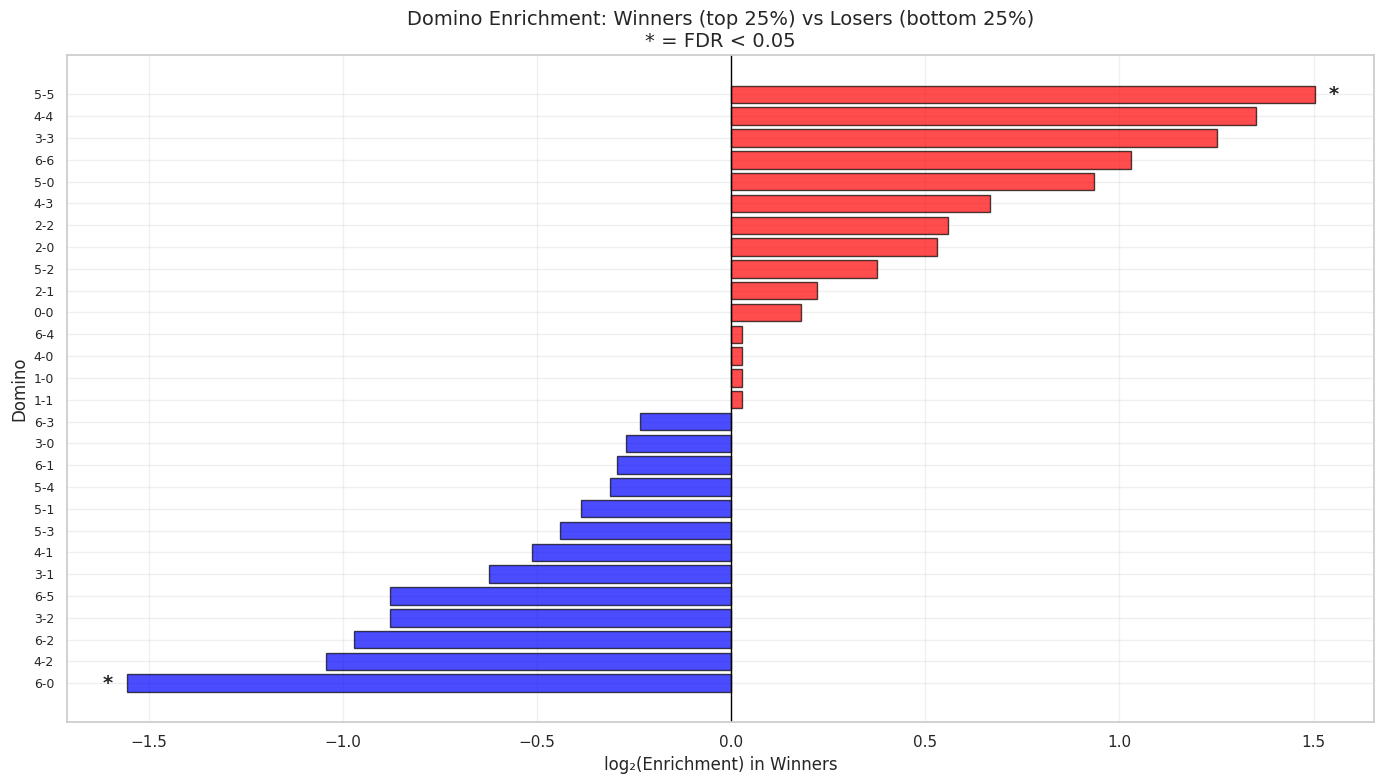

In [9]:
fig, ax = plt.subplots(figsize=(14, 8))

# Sort by log2_enrichment for display
sorted_df = results_df.sort_values('log2_enrichment', ascending=True)

colors = ['red' if x > 0 else 'blue' for x in sorted_df['log2_enrichment']]
bars = ax.barh(range(len(sorted_df)), sorted_df['log2_enrichment'], color=colors, alpha=0.7, edgecolor='black')

# Mark significant with asterisk
for i, (_, row) in enumerate(sorted_df.iterrows()):
    if row['significant']:
        ax.text(row['log2_enrichment'] + 0.05 * np.sign(row['log2_enrichment']), i, '*', 
                fontsize=14, fontweight='bold', ha='center', va='center')

ax.set_yticks(range(len(sorted_df)))
ax.set_yticklabels(sorted_df['domino'], fontsize=9)
ax.axvline(0, color='black', linewidth=1)
ax.set_xlabel('log₂(Enrichment) in Winners', fontsize=12)
ax.set_ylabel('Domino', fontsize=12)
ax.set_title('Domino Enrichment: Winners (top 25%) vs Losers (bottom 25%)\n* = FDR < 0.05', fontsize=14)

plt.tight_layout()
plt.savefig('../../results/figures/17a_enrichment_bars.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Save Results

In [10]:
# Save full results
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/17a_enrichment.csv"
results_df.to_csv(output_path, index=False)
print(f"Saved to {output_path}")

# Summary table
print("\n\nSummary: Significant Dominoes")
print("="*60)
sig_df = results_df[results_df['significant']].sort_values('log2_enrichment', ascending=False)
if len(sig_df) > 0:
    print(sig_df[['domino', 'freq_winners', 'freq_losers', 'log2_enrichment', 'p_adjusted']].to_string(index=False))
else:
    print("No dominoes significant at FDR < 0.05")

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/17a_enrichment.csv


Summary: Significant Dominoes
domino  freq_winners  freq_losers  log2_enrichment  p_adjusted
   5-5          0.50     0.176471         1.502500    0.016519
   6-0          0.16     0.470588        -1.556393    0.016519


## Key Findings

### Enrichment Analysis

Fisher's exact test with BH FDR correction identifies dominoes significantly over/under-represented in winning hands.

### Top Enriched Dominoes (More common in winners)

Typically doubles and high-value dominoes that win tricks.

### Top Depleted Dominoes (More common in losers)

Typically weak dominoes that don't win tricks.

### Interpretation

The enrichment pattern is consistent with the regression and SHAP analyses:
- Doubles are associated with higher E[V]
- Weak dominoes (like 6-0) hurt expected value

### Files Generated

- `results/tables/17a_enrichment.csv` - Full enrichment results
- `results/figures/17a_volcano_plot.png` - Volcano plot
- `results/figures/17a_enrichment_bars.png` - Bar plot